In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def load_image(infilename) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="uint8")
    return data

def rescale_images(images, scale):
    if type(scale) == float:
        return np.stack([cv2.resize(images[:,:,i], None, fx=scale, fy=scale) for i in range(images.shape[2])], 2)
    elif len(scale) == 2:
        return np.stack([cv2.resize(images[:,:,i], scale[::-1]) for i in range(images.shape[2])], 2)

def save_image(npdata, outfilename) :
    outimg = Image.fromarray(npdata, "RGB")
    outimg.save(outfilename)

def show_image(image):
    plt.ion()
    plt.imshow(image)
    plt.show()
    plt.pause(0.05)

def load_stylit_images(guidance_influence = 2.0, style = "style", channels = ("fullgi", "dirdif", "dirspc", "indirb"), scale=1.0):
    '''
    Outputs:
        - source: [:, :, :3] the place for stylized image
                  [:, :, 3:] the image with different shading considerations (e.g. diffuse, specular, ...)
        - target: [:, :, :3] simple sphere indicating the desired style
                  [:, :, 3:] simple sphere indicating different channels of lighting
        - channel_weights
    '''
    prefix = "images/source_"
    suffix = ".png"
    source = np.concatenate([load_image(prefix + channel + suffix) for channel in (style,) + channels], 2)
    prefix = "images/target_"
    target = np.concatenate([load_image(prefix + channel + suffix) for channel in channels], 2)
    output = np.zeros((target.shape[0],target.shape[1],3), dtype="uint8")
    target = np.concatenate((output, target), 2)
    channel_weights = np.array([1.0]*3 + [guidance_influence/float(len(channels))]*3*len(channels))
    if scale != 1.0:
        source = rescale_images(source, scale)
        target = rescale_images(target, scale)
    return source, target, channel_weights

In [3]:
# =================== initializations of offsets and distance matrix ====================
def init_offsets_and_best_D(a_size, b_size, patch_size):
    r = patch_size//2
    offsets_y = r + np.random.randint(b_size[0]-2*r, size=a_size[:2]) - np.arange(a_size[0]).reshape((a_size[0],1))
    offsets_x = r + np.random.randint(b_size[1]-2*r, size=a_size[:2]) - np.arange(a_size[1]).reshape((1,a_size[1]))
    best_d = np.zeros(a_size[:2])
    offsets_and_best_D = np.stack((offsets_y, offsets_x, best_d), 2)
    return offsets_and_best_D

def assign_initial_D(a, b, offsets, patch_radius, channel_weights):
    height, width = offsets.shape[:2]
    for i in range(height):
        y = i
        for j in range(width):
            x = j
            offsets[i,j,2] = calculate_D(a, b, x, y, offsets[i,j,1], offsets[i,j,0], patch_radius, channel_weights)

def calculate_D(a, b, a_x, a_y, offset_x, offset_y, patch_radius, channel_weights):
    a_patch, b_patch, _, _, _, _ = get_correctly_cropped_patches(a, b, a_x, a_y, offset_x, offset_y, patch_radius)
    diff = a_patch - b_patch
    if channel_weights is None:
        return np.sum(diff * diff)
    else:
        return np.inner(np.sum(diff * diff, (0,1)), channel_weights)
            
def init_random_offsets(a, b, patch_size, channel_weights):
    offsets = init_offsets_and_best_D(a.shape, b.shape, patch_size)
    assign_initial_D(a, b, offsets, patch_size//2, channel_weights)
    return offsets


# ======================== get correlated patches =============================
def get_patch(image, x, y, patch_radius): # x,y specifies the pixel position of a patch center
    return image[int(y) - patch_radius: int(y) + patch_radius + 1, int(x) - patch_radius: int(x) + patch_radius + 1]

def get_correctly_cropped_patches(a, b, a_x, a_y, offset_x, offset_y, patch_radius):
    if 0 <= a_y - patch_radius and a_y + patch_radius < a.shape[0] and 0 <= a_x - patch_radius and a_x + patch_radius < a.shape[1]:
        return get_patch(a, a_x, a_y, patch_radius), get_patch(b, a_x+offset_x, a_y+offset_y, patch_radius), patch_radius, patch_radius, patch_radius, patch_radius
    else:
        # Handle regions closer to the boundary than patch_radius
        up_patch_radius = patch_radius - max(patch_radius - a_y, 0)
        left_patch_radius = patch_radius - max(patch_radius - a_x, 0)
        down_patch_radius = patch_radius - max(patch_radius + a_y - (a.shape[0] - 1), 0)
        right_patch_radius = patch_radius - max(patch_radius + a_x - (a.shape[1] - 1), 0)
        a_patch, b_patch = [
            image[int(y - up_patch_radius): int(y + down_patch_radius) + 1,
            int(x - left_patch_radius): int(x + right_patch_radius) + 1] for (image, x, y) in
            ((a, a_x, a_y), (b, a_x + offset_x, a_y + offset_y))]
        return a_patch, b_patch, up_patch_radius, left_patch_radius, down_patch_radius, right_patch_radius

    
# ========================== omega for patches usage ============================
def init_omega(a, b, offsets, patch_radius):
    omega = np.zeros((offsets.shape[0], offsets.shape[1]), dtype=int)
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            y = i+offsets[i,j,0]
            x = j+offsets[i,j,1]
            omega[int(y)-patch_radius:int(y)+patch_radius+1, int(x)-patch_radius:int(x)+patch_radius+1] += 1
    return omega

def patch_omega(omega, x, y, patch_radius):
    return np.sum(omega[int(y)-patch_radius:int(y)+patch_radius+1, int(x)-patch_radius:int(x)+patch_radius+1])

def add_to_omega(omega, x, y, patch_radius, addition):
    omega[int(y)-patch_radius:int(y)+patch_radius+1, int(x)-patch_radius:int(x)+patch_radius+1] += addition


# ======================== propagate and random search =============================
def propagate(offsets, i, j, delta_i, delta_j, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size):
    neighbor_offset_y, neighbor_offset_x, neighbor_best_D = offsets[i + delta_i, j + delta_j]
    if y+neighbor_offset_y-patch_radius < 0 or y+neighbor_offset_y+patch_radius >= b.shape[0] \
        or x+neighbor_offset_x-patch_radius < 0 or x+neighbor_offset_x+patch_radius >= b.shape[1]:
        return # Patch ends up outside B when using the neighbor's offset, so don't use it

    try_patch(offsets, a, b, x, y, neighbor_offset_x, neighbor_offset_y, patch_radius, channel_weights, omega, omega_best,
              uniformity_weight, patch_size)

def random_search(offsets, i, j, search_windows, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size):
    min_offset = -np.array([i, j]) + patch_radius
    max_offset = min_offset + np.array(b.shape[:2]) - 2*patch_radius
    for window_radius in search_windows:
        min_window = np.maximum(min_offset, offsets[i, j, :2] - window_radius)
        max_window = np.minimum(max_offset, offsets[i, j, :2] + window_radius)
        try_offset_y = np.random.randint(min_window[0], max_window[0])
        try_offset_x = np.random.randint(min_window[1], max_window[1])

        try_patch(offsets, a, b, x, y, try_offset_x, try_offset_y, patch_radius, channel_weights, omega,
                  omega_best,
                  uniformity_weight, patch_size)
# try new patches, use them instead of the current offsets if they are better
def try_patch(offsets, a, b, x, y, try_offset_x, try_offset_y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size):
    D_using_try_offset = calculate_D(a, b, x, y, try_offset_x, try_offset_y, patch_radius, channel_weights)  # (Can optimize this)

    curr_occ = patch_omega(omega, x + offsets[y,x,1], y + offsets[y,x,0], patch_radius)/(patch_size*patch_size)/omega_best
    new_occ = patch_omega(omega, x + try_offset_x, y + try_offset_y, patch_radius)/(patch_size*patch_size)/omega_best
    if D_using_try_offset + uniformity_weight*new_occ < offsets[y, x, 2] + uniformity_weight*curr_occ:
        add_to_omega(omega, x + offsets[y,x,1], y + offsets[y,x,0], patch_radius, -1)
        add_to_omega(omega, x + try_offset_x, y + try_offset_y, patch_radius, +1)
        offsets[y, x, :] = try_offset_y, try_offset_x, D_using_try_offset

# =========================== upscaling offsets =================================
def upscaled_offsets(offsets, a, b, patch_size, channel_weights):
    upsize = np.ones((2,2))
    new_offsets = 2 * np.stack((np.kron(offsets[:,:,0], upsize),
                                np.kron(offsets[:,:,1], upsize),
                                np.zeros(np.array(offsets.shape[:2])*2)), 2)
    assign_initial_D(a, b, new_offsets, patch_size//2, channel_weights)
    return new_offsets

# ========================== main algorithm for patchmatch =============================
def patchmatch(a, b, offsets, patchmatch_iterations = 6, patch_size = 5, iteration_callback=None, scanline_callback_every_nth=50, channel_weights=None):
    patch_radius = patch_size // 2
    height, width = offsets.shape[:2]
    max_search_radius = max(height, width)
    window_size_ratio = 0.5
    num_search_windows = 1 + int(-np.log(max_search_radius)/np.log(window_size_ratio)) # All possible windows larger than 1 pixel
    print("num_search_windows = " + str(num_search_windows))
    search_windows = [max_search_radius * window_size_ratio ** i for i in range(num_search_windows)] # sizes of all search windows
    
    # for uniformity purpose (avoid using one specific patch too often)
    omega = init_omega(a, b, offsets, patch_radius)
    omega_best = patch_size*patch_size * a.shape[0]*a.shape[1] / (b.shape[0]*b.shape[1])
    uniformity_weight = 3500
    
    # iteration
    for patchmatch_iteration in range(patchmatch_iterations):
        if patchmatch_iteration % 2 == 0: # Right-down iteration
            for i in range(height):
                y = i
                for j in range(width):
                    x = j
                    # Propagation
                    if j > 0:
                        propagate(offsets, i, j, 0, -1, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size)
                    if i > 0:
                        propagate(offsets, i, j, -1, 0, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size)
                    # Random search
                    random_search(offsets, i, j, search_windows, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size)
                if i % scanline_callback_every_nth == 0:
                    if iteration_callback is not None:
                        iteration_callback(patchmatch_iteration, i, offsets, a, b, patch_radius)
        else:# Left-up iteration
            for i in range(height-1,-1,-1):
                y = i
                for j in range(width-1,-1,-1):
                    x = j
                    # Propagation
                    if j < width-1:
                        propagate(offsets, i, j, 0, 1, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size)
                    if i < height-1:
                        propagate(offsets, i, j, 1, 0, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size)
                    # Random search
                    random_search(offsets, i, j, search_windows, a, b, x, y, patch_radius, channel_weights, omega, omega_best, uniformity_weight, patch_size)
            if i % scanline_callback_every_nth == 0:
                if iteration_callback is not None:
                    iteration_callback(patchmatch_iteration, i, offsets, a, b, patch_radius)
        if iteration_callback is not None:
            iteration_callback(patchmatch_iteration, None, offsets, a, b, patch_radius)
    return offsets

def iteration_callback(iteration, scanline, offsets, a, b, patch_radius):
    if scanline is None:
        print("Patchmatch iteration " + str(iteration))
    else:
        print("   Scanline " + str(scanline))
    show_image(reconstruct_image(offsets, a[:,:,:3], b[:,:,:3], patch_radius))


# =================== Reconstruct an image using the calculated offsets =====================
def reconstruct_image(offsets, a, b, patch_radius):
    reconstruction = np.zeros(a.shape)
    count = np.zeros(a.shape)
    height, width = offsets.shape[:2]
    for i in range(height):
        y = i
        for j in range(width):
            #reconstruction[i, j, :] = b[int(i + offsets[i, j, 0]), int(j + offsets[i, j, 1]), :]
            x = j
            _, b_patch, up_patch_radius, left_patch_radius, down_patch_radius, right_patch_radius = get_correctly_cropped_patches(a, b, x, y, offsets[i, j, 1], offsets[i, j, 0], patch_radius)
            reconstruction[int(y - up_patch_radius): int(y + down_patch_radius) + 1, int(x - left_patch_radius): int(x + right_patch_radius) + 1] += b_patch
            count[int(y - up_patch_radius): int(y + down_patch_radius) + 1, int(x - left_patch_radius): int(x + right_patch_radius) + 1] += 1
    reconstruction /= count
    return reconstruction.astype("uint8")

num_search_windows = 5
   Scanline 0


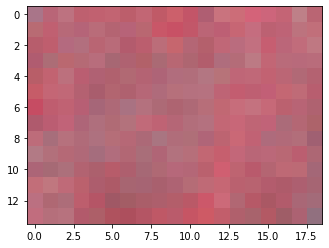

Patchmatch iteration 0


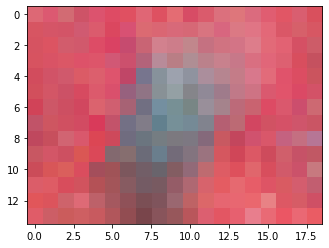

   Scanline 0


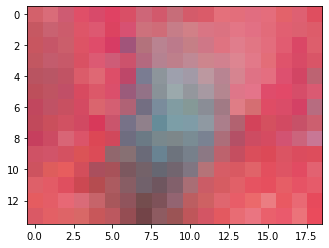

Patchmatch iteration 1


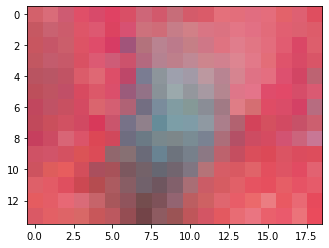

   Scanline 0


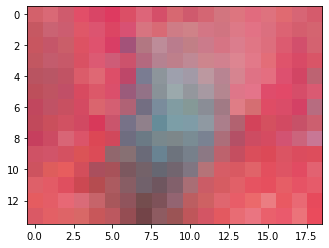

Patchmatch iteration 2


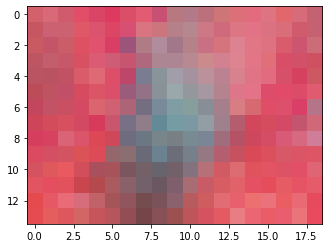

   Scanline 0


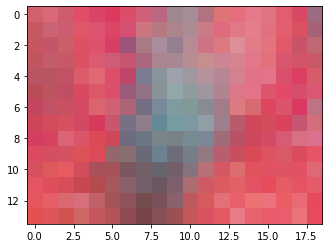

Patchmatch iteration 3


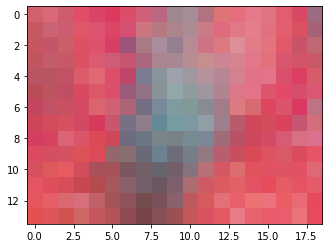

Finished texture syntesis iteration 0


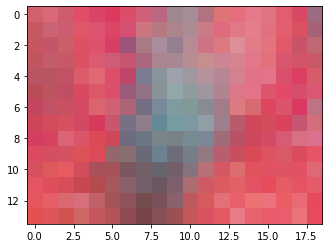

num_search_windows = 5
   Scanline 0


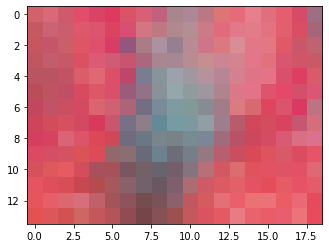

Patchmatch iteration 0


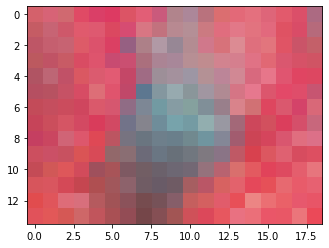

   Scanline 0


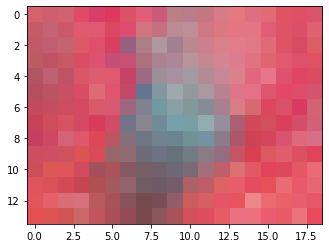

Patchmatch iteration 1


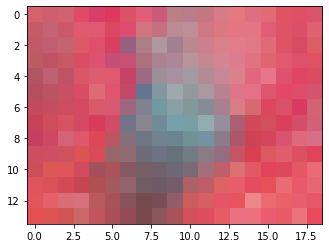

   Scanline 0


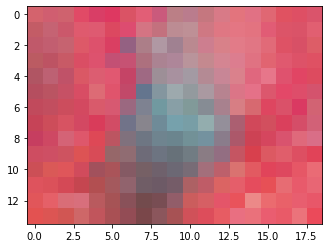

Patchmatch iteration 2


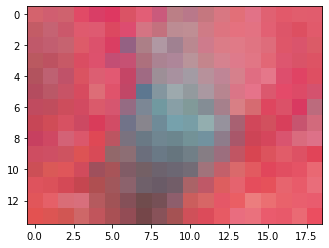

   Scanline 0


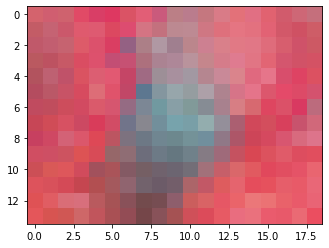

Patchmatch iteration 3


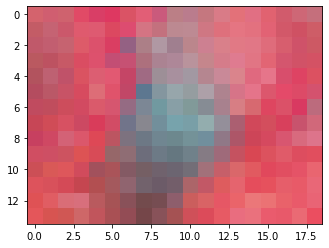

Finished texture syntesis iteration 1


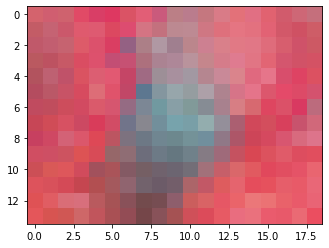

num_search_windows = 5
   Scanline 0


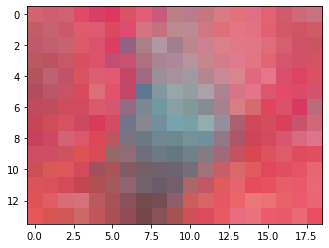

Patchmatch iteration 0


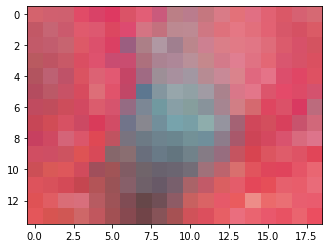

   Scanline 0


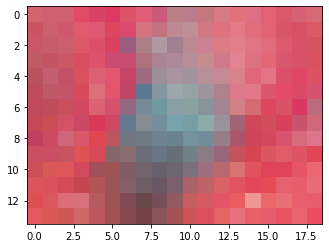

Patchmatch iteration 1


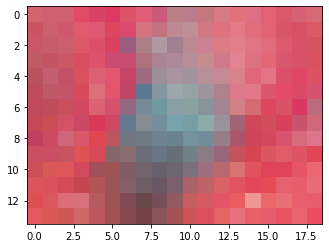

   Scanline 0


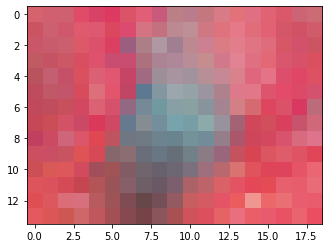

Patchmatch iteration 2


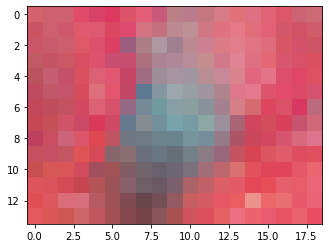

   Scanline 0


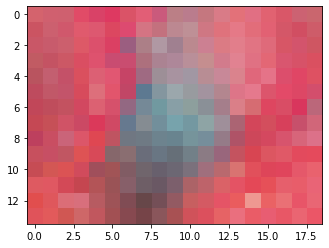

Patchmatch iteration 3


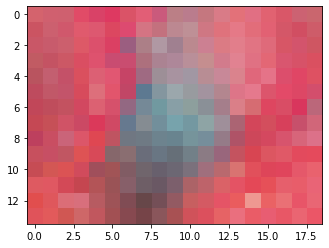

Finished texture syntesis iteration 2


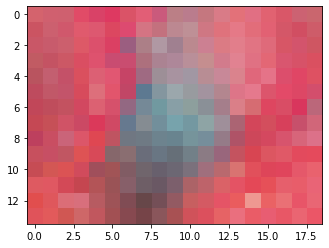

num_search_windows = 5
   Scanline 0


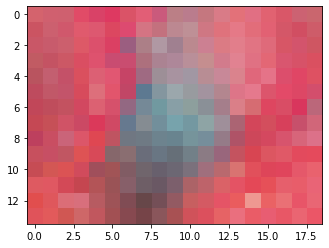

Patchmatch iteration 0


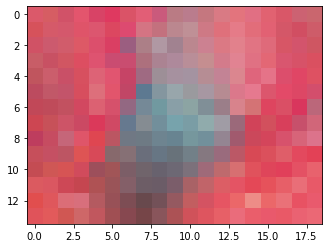

   Scanline 0


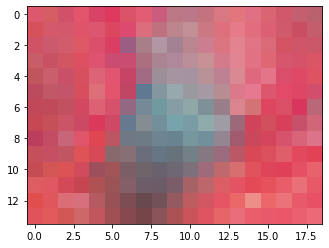

Patchmatch iteration 1


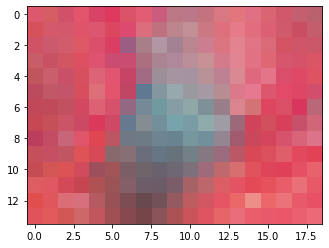

   Scanline 0


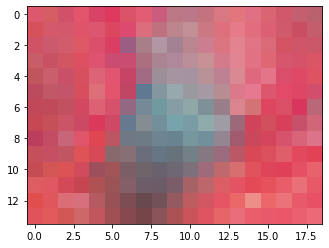

Patchmatch iteration 2


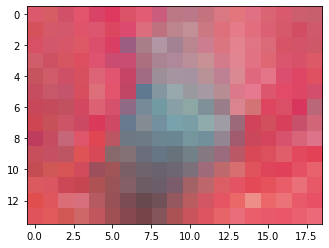

   Scanline 0


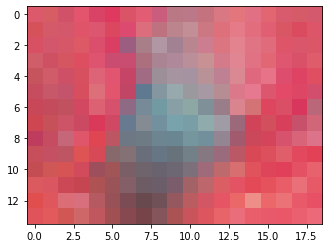

Patchmatch iteration 3


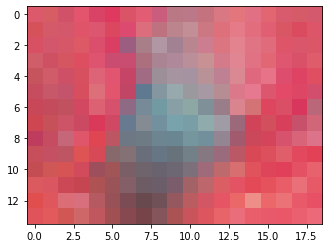

Finished texture syntesis iteration 3


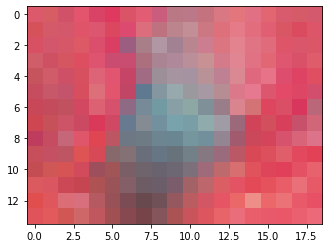

num_search_windows = 5
   Scanline 0


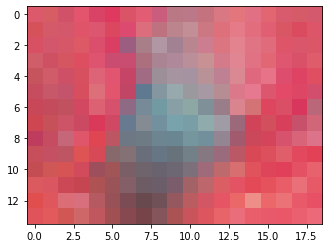

Patchmatch iteration 0


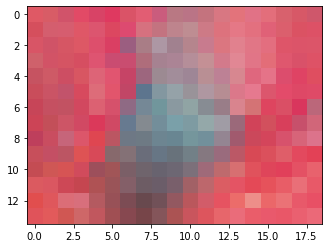

   Scanline 0


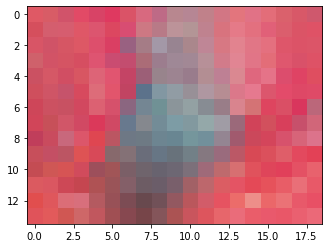

Patchmatch iteration 1


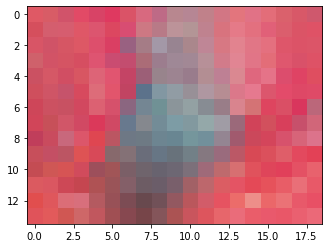

   Scanline 0


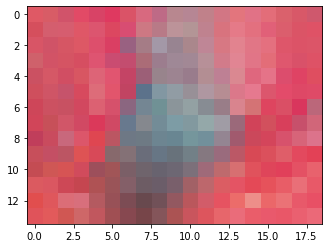

Patchmatch iteration 2


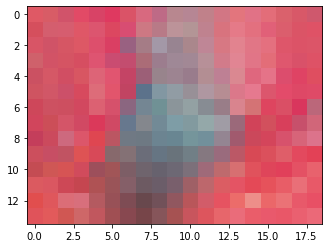

   Scanline 0


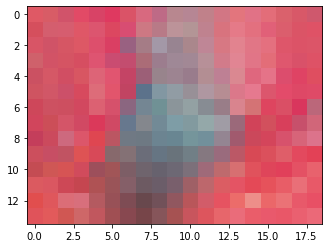

Patchmatch iteration 3


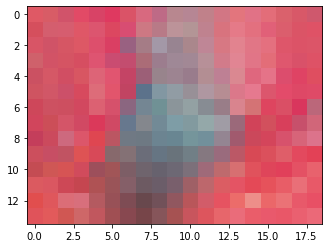

Finished texture syntesis iteration 4


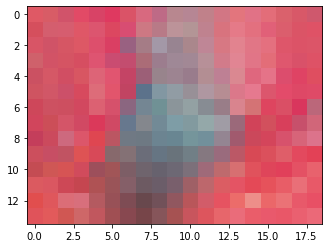

num_search_windows = 5
   Scanline 0


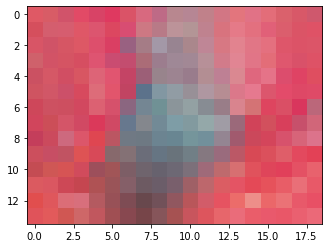

Patchmatch iteration 0


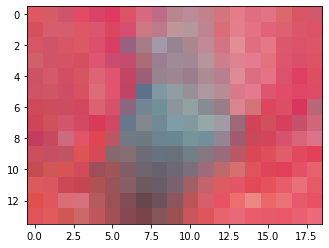

   Scanline 0


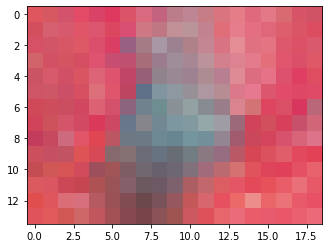

Patchmatch iteration 1


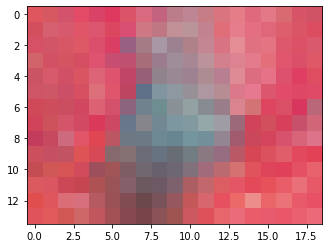

   Scanline 0


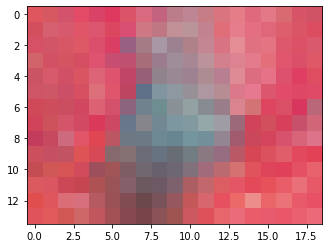

Patchmatch iteration 2


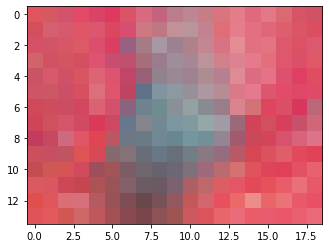

   Scanline 0


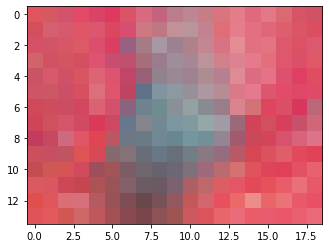

Patchmatch iteration 3


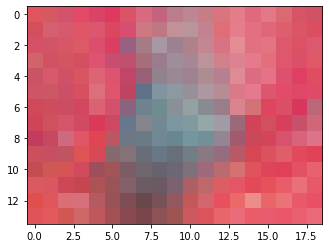

Finished texture syntesis iteration 5


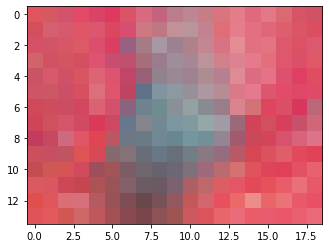

In [4]:
#if __name__ == "__main__":
num_pyramid_levels = 7  # 6
patch_size = 5
a_w, a_h = 400, 400

# loading images (including styles and contents)
source, target, channel_weights = load_stylit_images()
a = target
a_guides_original = np.copy(target[:,:,3:])
b_original = source
a = rescale_images(a, 0.5 ** (num_pyramid_levels - 1))
smallest_b_size = (np.array(b_original.shape[:2]) * 0.5 ** (num_pyramid_levels - 1)).astype(int)
b = rescale_images(b_original, smallest_b_size) # b = rescale_images(b_original, 0.5 ** (num_pyramid_levels - 1))

offsets = init_random_offsets(a, b, patch_size, channel_weights)
a[:, :, :3] = reconstruct_image(offsets, a[:, :, :3], b[:, :, :3], patch_size//2) # Initial reconstruction from the randomly initialized nearest-neighbor field

for pyramid_level in range(num_pyramid_levels):
    for iteration in range(6):
        if patch_size >= min(a_w, a_h, b.shape[0], b.shape[1]):
            continue
        offsets = patchmatch(a, b, offsets, patchmatch_iterations=4, patch_size=patch_size,
                             iteration_callback=iteration_callback, channel_weights=channel_weights)
        a[:,:,:3] = reconstruct_image(offsets, a[:,:,:3], b[:,:,:3], patch_size//2)
        print("Finished texture syntesis iteration " + str(iteration))
        show_image(a[:,:,:3])
    rescaled_output = rescale_images(a[:,:,:3], 2.0)
    save_image(a[:, :, :3], "results/output_level_" + str(pyramid_level) + ".png")
    if pyramid_level < num_pyramid_levels-1:
        a = np.concatenate((rescaled_output, rescale_images(a_guides_original, rescaled_output.shape[:2])), 2)
        b = rescale_images(b_original, smallest_b_size * 2 ** (pyramid_level+1))
        offsets = upscaled_offsets(offsets, a, b, patch_size, channel_weights)